In [48]:
# --------------------------------------------------------- Global Variables & Paths
# region
# @title Global Variables & Paths { display-mode: "form" }


# --------------- vscode
VS_CODE_RAW_DATA_SET_PATH = '../dogs-vs-cats/data/extracted_using_python/Dataset' # modify per data set
VS_CODE_CLEAN_DATA_SET_PATH = '../dogs-vs-cats/data/clean_data'

# --------------- kaggle
KAGGLE_RAW_DATA_SET_PATH = '/kaggle/input/arabic-letters-numbers-ocr/Dataset' # put (dataset name immediately after /input), and any extra folders modify per data set
KAGGLE_CLEAN_DATA_SET_PATH = '/kaggle/working/clean_data'


# --------------- colab
KAGGLE_CRED_PATH = '/content/gdrive/MyDrive/Bachelor/kaggle'
KAGGLE_DATA_SET_NAME = 'mahmoudreda55/arabic-letters-numbers-ocr'  # username/dataset name..t modify per data set

COLAB_RAW_DATA_SET_PATH = '/content/kaggle_data/Dataset' # put (dataset_name) after (kaggle_data) , then put any extra folders... modify the part after (kaggle_data) per data set
COLAB_CLAEN_DATA_SET_PATH = '/content/clean_data'

EPOCHS = 100
DATA_PERCENTAGE_TO_USE = 100
EXTRACT_ZIP = True
COPY_RAW_DATA = True
RENAME_CLEAN_DATA = True



# endregion

In [49]:
# --------------------------------------------------------- install libraries
# region
# @title install libraries { display-mode: "form" }

# %pip install --upgrade pillow pydrive2
# endregion

In [50]:
# --------------------------------------------------------- imports
# region
# @title imports { display-mode: "form" }

import os
import time
import uuid
import random
import warnings
import shutil
import zipfile
from os import makedirs
from os import listdir
from tqdm import tqdm
from shutil import copyfile
from random import seed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

print("imports done")

# endregion



imports done


In [51]:
# --------------------------------------------------------- functions
# region
# @title functions {display-mode: "form"}

raw_data_path = None
clean_data_path = None

def get_environment():
    if 'COLAB_GPU' in os.environ:
        return 'Google Colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'Kaggle'
    elif 'VSCODE_PID' in os.environ:
        return 'VS Code'
    else:
        return 'Unknown environment'

def do_colab_staff():

    from google.colab import drive
    drive.mount('/content/gdrive')

    # storing kaggle credentials
    os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_CRED_PATH

    !kaggle datasets download -d {KAGGLE_DATA_SET_NAME}
    print("downloaded dataset" ,KAGGLE_DATA_SET_NAME )
    
    if EXTRACT_ZIP:
        ! mkdir kaggle_data
        downloaded_zip_name = f"{KAGGLE_DATA_SET_NAME.split('/')[-1]}.zip" # the !kaggle datasets download command will download the zip file with the same name as the dataset name
        extract_folder_path = 'kaggle_data'
        extract_zip(downloaded_zip_name, extract_folder_path)

    global raw_data_path
    raw_data_path = COLAB_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = COLAB_CLAEN_DATA_SET_PATH


def do_kaggle_staff():
    global raw_data_path
    raw_data_path = KAGGLE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = KAGGLE_CLEAN_DATA_SET_PATH
    
def do_vscode_staff():
    global raw_data_path
    raw_data_path = VS_CODE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = VS_CODE_CLEAN_DATA_SET_PATH

def do_unknown_environment_staff():
    print("This is an unknown environment, please enter the path to the data set folder:")
    global raw_data_path
    raw_data_path = input()     

def image_is_ok(image_path):
    with warnings.catch_warnings(record=True) as w:
        try:
            img = Image.open(image_path)
            img.verify()
            if len(w) > 0:  # if any warnings were issued
                return False
            return True
        except (IOError, SyntaxError):
            return False

def copy_clean_files(dirty_dataset_path, destination_folder_path):
    print("copying clean files...")
    # If the destination directory already exists, remove it and all its contents
    if os.path.exists(destination_folder_path):
        shutil.rmtree(destination_folder_path)
        print(f"removed {destination_folder_path} directory to create a new one...")
    os.makedirs(destination_folder_path)
    for root, dirs, files in os.walk(dirty_dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            if image_is_ok(file_path):
                new_file_path = os.path.join(destination_folder_path, os.path.relpath(file_path, dirty_dataset_path))
                os.makedirs(os.path.dirname(new_file_path) , exist_ok=True)
                shutil.copyfile(file_path, new_file_path)
            else:
                # print(f"file: {file_path} is corrupted & skipped from dataset while copying ")    
                 print(f"file: {os.path.relpath(file_path, dirty_dataset_path)} is corrupted & skipped from dataset while copying ")
    print(f"copied files from {dirty_dataset_path} to {destination_folder_path} successfully")             

def rename_files(data_set_path):
    all_entities_names = os.listdir(data_set_path)
    print("giving temporary unique names...")
    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        for filename in os.listdir(entity_path):
            temp_filename = str(uuid.uuid4()) + ".jpg"  # generate a unique filename
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, temp_filename)
            os.rename(source, destination)
    # ----------------------------------------------------------------------------------------------------
    print("renaming...")
    # then rename every file in every folder in the given path

    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        i = 1
        for filename in os.listdir(entity_path):
            entity_name = os.fsdecode(entity_name.lower())
            new_filename = entity_name + '.' + str(i) + ".jpg"
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, new_filename)
            os.rename(source, destination)
            i += 1
    print("done renaming !")

def find_image_folder_after_extracting_zip(extracted_folder_path):
    for root, dirs, files in os.walk(extracted_folder_path):
        # check if the current directory contains image files
        if any(fname.lower().endswith(('.png', '.jpg', '.jpeg')) for fname in files):
            return os.path.dirname(root)
    return None
print("functions done")  

def extract_zip(source_path, destination_path):
    # delete the destination folder if it exists
    if os.path.exists(destination_path):
        print('Deleting the existing destination folder...')
        shutil.rmtree(destination_path)

    print("Extracting files...") 
    with zipfile.ZipFile(source_path, 'r') as zip_ref:
        files = zip_ref.infolist()
        for file in tqdm(files, desc="Extracting files", unit="file"):
            try:
                file.filename = file.filename.encode('cp437').decode('utf-8')  # try 'cp437' encoding first
            except UnicodeDecodeError:
                file.filename = file.filename.encode('utf-8').decode('utf-8')  # fallback to 'utf-8' if 'cp437' fails
            zip_ref.extract(file, path=destination_path)

    print("Extraction complete.")



# endregion

    

functions done


In [52]:
# --------------------------------------------------------- doing specific-environment things
# region
# @title doing specific-environment things {display-mode: "form"}

# test if the GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus if gpus else "No GPU available, using CPU instead.")

raw_data_path = None    
environment_type = get_environment() 
print(f'Environment: {environment_type}')       
print("tensowflow version:", tf.__version__)
if environment_type == 'Google Colab':
    do_colab_staff()
elif environment_type == 'Kaggle':
    do_kaggle_staff()
elif environment_type == 'VS Code':
    do_vscode_staff()
else:
    do_unknown_environment_staff()

print("raw data set path:", raw_data_path)
assert os.path.exists(raw_data_path), ' wrong path for data set !' 
print("clean data set path:", clean_data_path)
  

print("doing specific-environment things done")

# endregion

        


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Environment: Kaggle
tensowflow version: 2.15.0
raw data set path: /kaggle/input/arabic-letters-numbers-ocr/Dataset
clean data set path: /kaggle/working/clean_data
doing specific-environment things done


In [53]:
# --------------------------------------------------------- data preparation
# region
# @title data preparation {display-mode: "form"}

start_time = time.time()

print("raw data path:", raw_data_path)
parent_dir = os.path.dirname(raw_data_path)
print("raw data parent dir:", parent_dir)
print("clean data path:", clean_data_path)

if(COPY_RAW_DATA):
    copy_clean_files(raw_data_path, clean_data_path)
if(RENAME_CLEAN_DATA):
    rename_files(clean_data_path)
ready_data_path = clean_data_path

print("we will only use ", DATA_PERCENTAGE_TO_USE, "% of the data")
print("data preparation done")


# endregion
        


raw data path: /kaggle/input/arabic-letters-numbers-ocr/Dataset
raw data parent dir: /kaggle/input/arabic-letters-numbers-ocr
clean data path: /kaggle/working/clean_data
copying clean files...
removed /kaggle/working/clean_data directory to create a new one...
file: ل/main.py is corrupted & skipped from dataset while copying 
copied files from /kaggle/input/arabic-letters-numbers-ocr/Dataset to /kaggle/working/clean_data successfully
giving temporary unique names...
renaming...
done renaming !
we will only use  100 % of the data
data preparation done


In [54]:
# 1 --------------------------------------------------------- Loading Images in a Dataframe
# region
# @title 1 - Loading Images in a Dataframe { display-mode: "form" }

all_entities_names = os.listdir(ready_data_path)
print("all entities names:", all_entities_names)
filenames = []
original_data_set_size = 0
for entity_name in all_entities_names:
    entity_path = os.path.join(ready_data_path, entity_name)
    entity_filenames = [file_name for file_name in os.listdir(entity_path)]
    original_data_set_size += len(entity_filenames)
    random.shuffle(entity_filenames)
    entity_filenames = entity_filenames[:int(len(entity_filenames) * (DATA_PERCENTAGE_TO_USE / 100))]
    filenames.extend([os.path.join(entity_name, file_name) for file_name in entity_filenames])

print(f"selected data set size = {DATA_PERCENTAGE_TO_USE / 100} * {original_data_set_size} = {len(filenames)}") 
file_labels = [x.split(os.sep)[0] for x in filenames] 
data = pd.DataFrame({"filename": filenames, "label": file_labels})

print("Loading Images in a Dataframe done")
# endregion


all entities names: ['ز', 'ن', 'ق', 'ح', '٥', 'ج', 'ل', '٤', 'م', 'ك', 'ر', 'ا', '٦', 'لا', '١', 'ب', '٨', '٩', 'ت', '٧', 'ع', '٠', '٣', 'د', 'ص', 'ف', 'ذ', 'خ', 'س', 'ظ', 'ي', 'ط', '٢', 'غ', 'و', 'ض', 'ش', 'ه', 'ث']
selected data set size = 1.0 * 96749 = 96749
Loading Images in a Dataframe done


In [55]:
# 2 --------------------------------------------------------- Train Test Split
# region
# @title 2 - Train Test Split { display-mode: "form" }

lables = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=lables, random_state = 42)
label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print(" ")
print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)
print(" ")

# endregion


 
The shape of train data (77399, 2)
The shape of test data (9675, 2)
The shape of validation data (9675, 2)
 


In [56]:
# 3 --------------------------------------------------------- Creating Image Data Generator
# region
# @title 3 - Creating Image Data Generator  { display-mode: "form" }

image_size = 128
image_channel = 3
bat_size = 32

# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying image data gernerator to train and test data

# print("all entities path : ", all_entities_path)
# print ("X_train head: ", X_train.head())
# print ("X_val head: ", X_val.head())
# print ("X_test head: ", X_test.head())

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                class_mode='categorical')
# print("tain generator indicise : " ,train_generator.class_indices)
# print("corrupted files : ", corrupted_file_paths)
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

print("Creating Image Data Generator done")

# endregion



Found 77399 validated image filenames belonging to 39 classes.
Found 9675 validated image filenames belonging to 39 classes.
Found 9675 validated image filenames belonging to 39 classes.
Creating Image Data Generator done


In [57]:
# 4 --------------------------------------------------------- Deep Learning Model
# region
# @title 4 - Deep Learning Model { display-mode: "form" }

model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
# get the number of classes
num_classes = len(train_generator.class_indices)
model.add(Dense(num_classes,activation='softmax'))
# model.summary()

print("Deep Learning Model done")

# endregion



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Deep Learning Model done


In [58]:
# 5 --------------------------------------------------------- Callbacks
# region
# @title 5 - Callbacks { display-mode: "form" }
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

print("Callbacks done")

# endregion


Callbacks done


In [59]:
# 6 --------------------------------------------------------- Model Compilation
# region
# @title 6 - Model Compilation { display-mode: "form" }

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

print("Model Compilation done")

# endregion

#

Model Compilation done


In [60]:
# 7 --------------------------------------------------------- Model Fitting
# region
# @title 7 - Model Fitting { display-mode: "form" }

print("number of samples in train generator: ", train_generator.samples)
print("number of samples in test generator: ", test_generator.samples)
print("batch size: ", bat_size)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)

training_history = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = EPOCHS,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                   )

print("Model Fitting done")
# endregion

#

number of samples in train generator:  77399
number of samples in test generator:  9675
batch size:  32
steps_per_epoch:  2418
validation_steps:  302
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   3/2418 ━━━━━━━━━━━━━━━━━━━━ 3:32 88ms/step - accuracy: 0.0295 - loss: 4.6454      

W0000 00:00:1710723501.500476     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 810/2418 ━━━━━━━━━━━━━━━━━━━━ 3:57 148ms/step - accuracy: 0.5615 - loss: 1.5736

W0000 00:00:1710723620.670692     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2418/2418 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7209 - loss: 0.9679

W0000 00:00:1710723824.172448     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2418/2418 ━━━━━━━━━━━━━━━━━━━━ 341s 135ms/step - accuracy: 0.7210 - loss: 0.9677 - val_accuracy: 0.9815 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 2/100
   1/2418 ━━━━━━━━━━━━━━━━━━━━ 1:06 27ms/step - accuracy: 0.9375 - loss: 0.2978

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2418/2418 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.9375 - loss: 0.2978 - val_accuracy: 1.0000 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 3/100


W0000 00:00:1710723829.875507     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2418/2418 ━━━━━━━━━━━━━━━━━━━━ 302s 125ms/step - accuracy: 0.9398 - loss: 0.1867 - val_accuracy: 0.9901 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 4/100
   1/2418 ━━━━━━━━━━━━━━━━━━━━ 1:05 27ms/step - accuracy: 0.9688 - loss: 0.0390
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.9688 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 5/100
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 302s 125ms/step - accuracy: 0.9704 - loss: 0.0939 - val_accuracy: 0.9941 - val_loss: 0.0200 - learning_rate: 5.0000e-04
Epoch 6/100
   1/2418 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.9375 - loss: 0.1264
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.9375 - loss: 0.1264 - val_accuracy: 1.0000 - val_loss: 7.2858e-04 - learning_rate: 5.0000e-04
Epoch 7/100
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 305s 126ms/step 

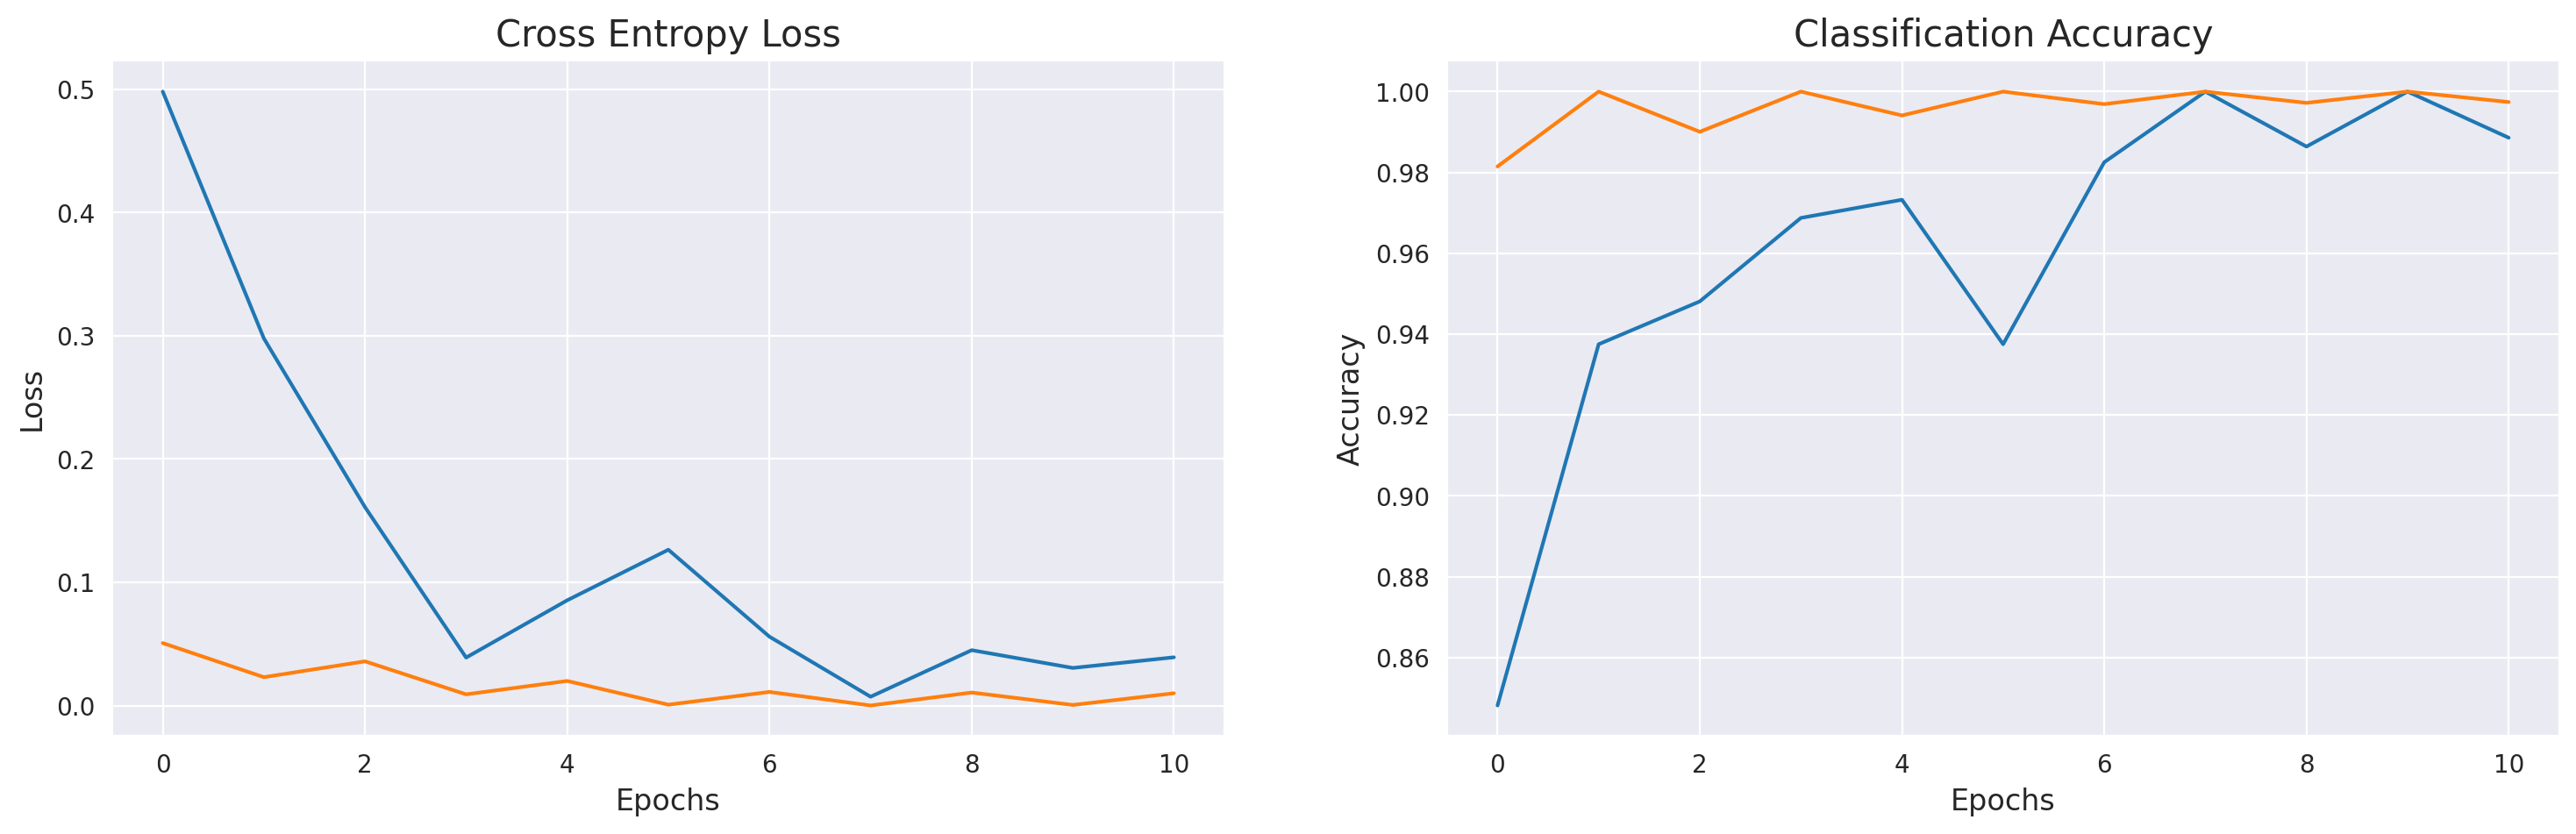

Plot the results done


In [61]:
# 8 --------------------------------------------------------- Plot the results
# region
# @title 8 - Plot the results { display-mode: "form" }
# plots for accuracy and Loss with epochs

error = pd.DataFrame(training_history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show(block=False)  # hosain : prevent the popup

print("Plot the results done")

# endregion

#

In [62]:
# 9 --------------------------------------------------------- Evaluation
# region
# @title 9 - Evaluation { display-mode: "form" }
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

#  endregion

#

W0000 00:00:1710725635.194309     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


The accuracy of the model for training data is: 99.04779195785522
The Loss of the model for training data is: 0.031356457620859146
The accuracy of the model for validation data is: 99.67958927154541
The Loss of the model for validation data is: 0.010975773446261883


In [63]:
# 10 --------------------------------------------------------- save the model
# region
# @title 10 - save the model { display-mode: "form" }
model.save("model.keras")

print("Model saved")
# endregion

#

Model saved


In [64]:
# 11 --------------------------------------------------------- Prediction
# region
# @title 11 - Prediction { display-mode: "form" }
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

# endregion

#

W0000 00:00:1710725640.389646     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710725644.987892     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


The accuracy of the model for testing data is: 99.61757063865662
The Loss of the model for testing data is: 0.017773250117897987


In [65]:
# 12 --------------------------------------------------------- Classification Report
# region
# @title 12 - Classification Report { display-mode: "form" }

print("all entities names:", all_entities_names)
print(classification_report(y_true, y_pred,target_names=all_entities_names))

# endregion

#

all entities names: ['ز', 'ن', 'ق', 'ح', '٥', 'ج', 'ل', '٤', 'م', 'ك', 'ر', 'ا', '٦', 'لا', '١', 'ب', '٨', '٩', 'ت', '٧', 'ع', '٠', '٣', 'د', 'ص', 'ف', 'ذ', 'خ', 'س', 'ظ', 'ي', 'ط', '٢', 'غ', 'و', 'ض', 'ش', 'ه', 'ث']
              precision    recall  f1-score   support

           ز       1.00      0.99      0.99       248
           ن       0.99      1.00      1.00       248
           ق       0.99      0.97      0.98       248
           ح       0.97      0.99      0.98       248
           ٥       1.00      1.00      1.00       248
           ج       1.00      1.00      1.00       248
           ل       1.00      1.00      1.00       248
           ٤       1.00      1.00      1.00       248
           م       1.00      0.99      0.99       248
           ك       1.00      1.00      1.00       248
           ر       0.99      1.00      1.00       249
           ا       1.00      1.00      1.00       248
           ٦       1.00      1.00      1.00       248
          لا       0.99   

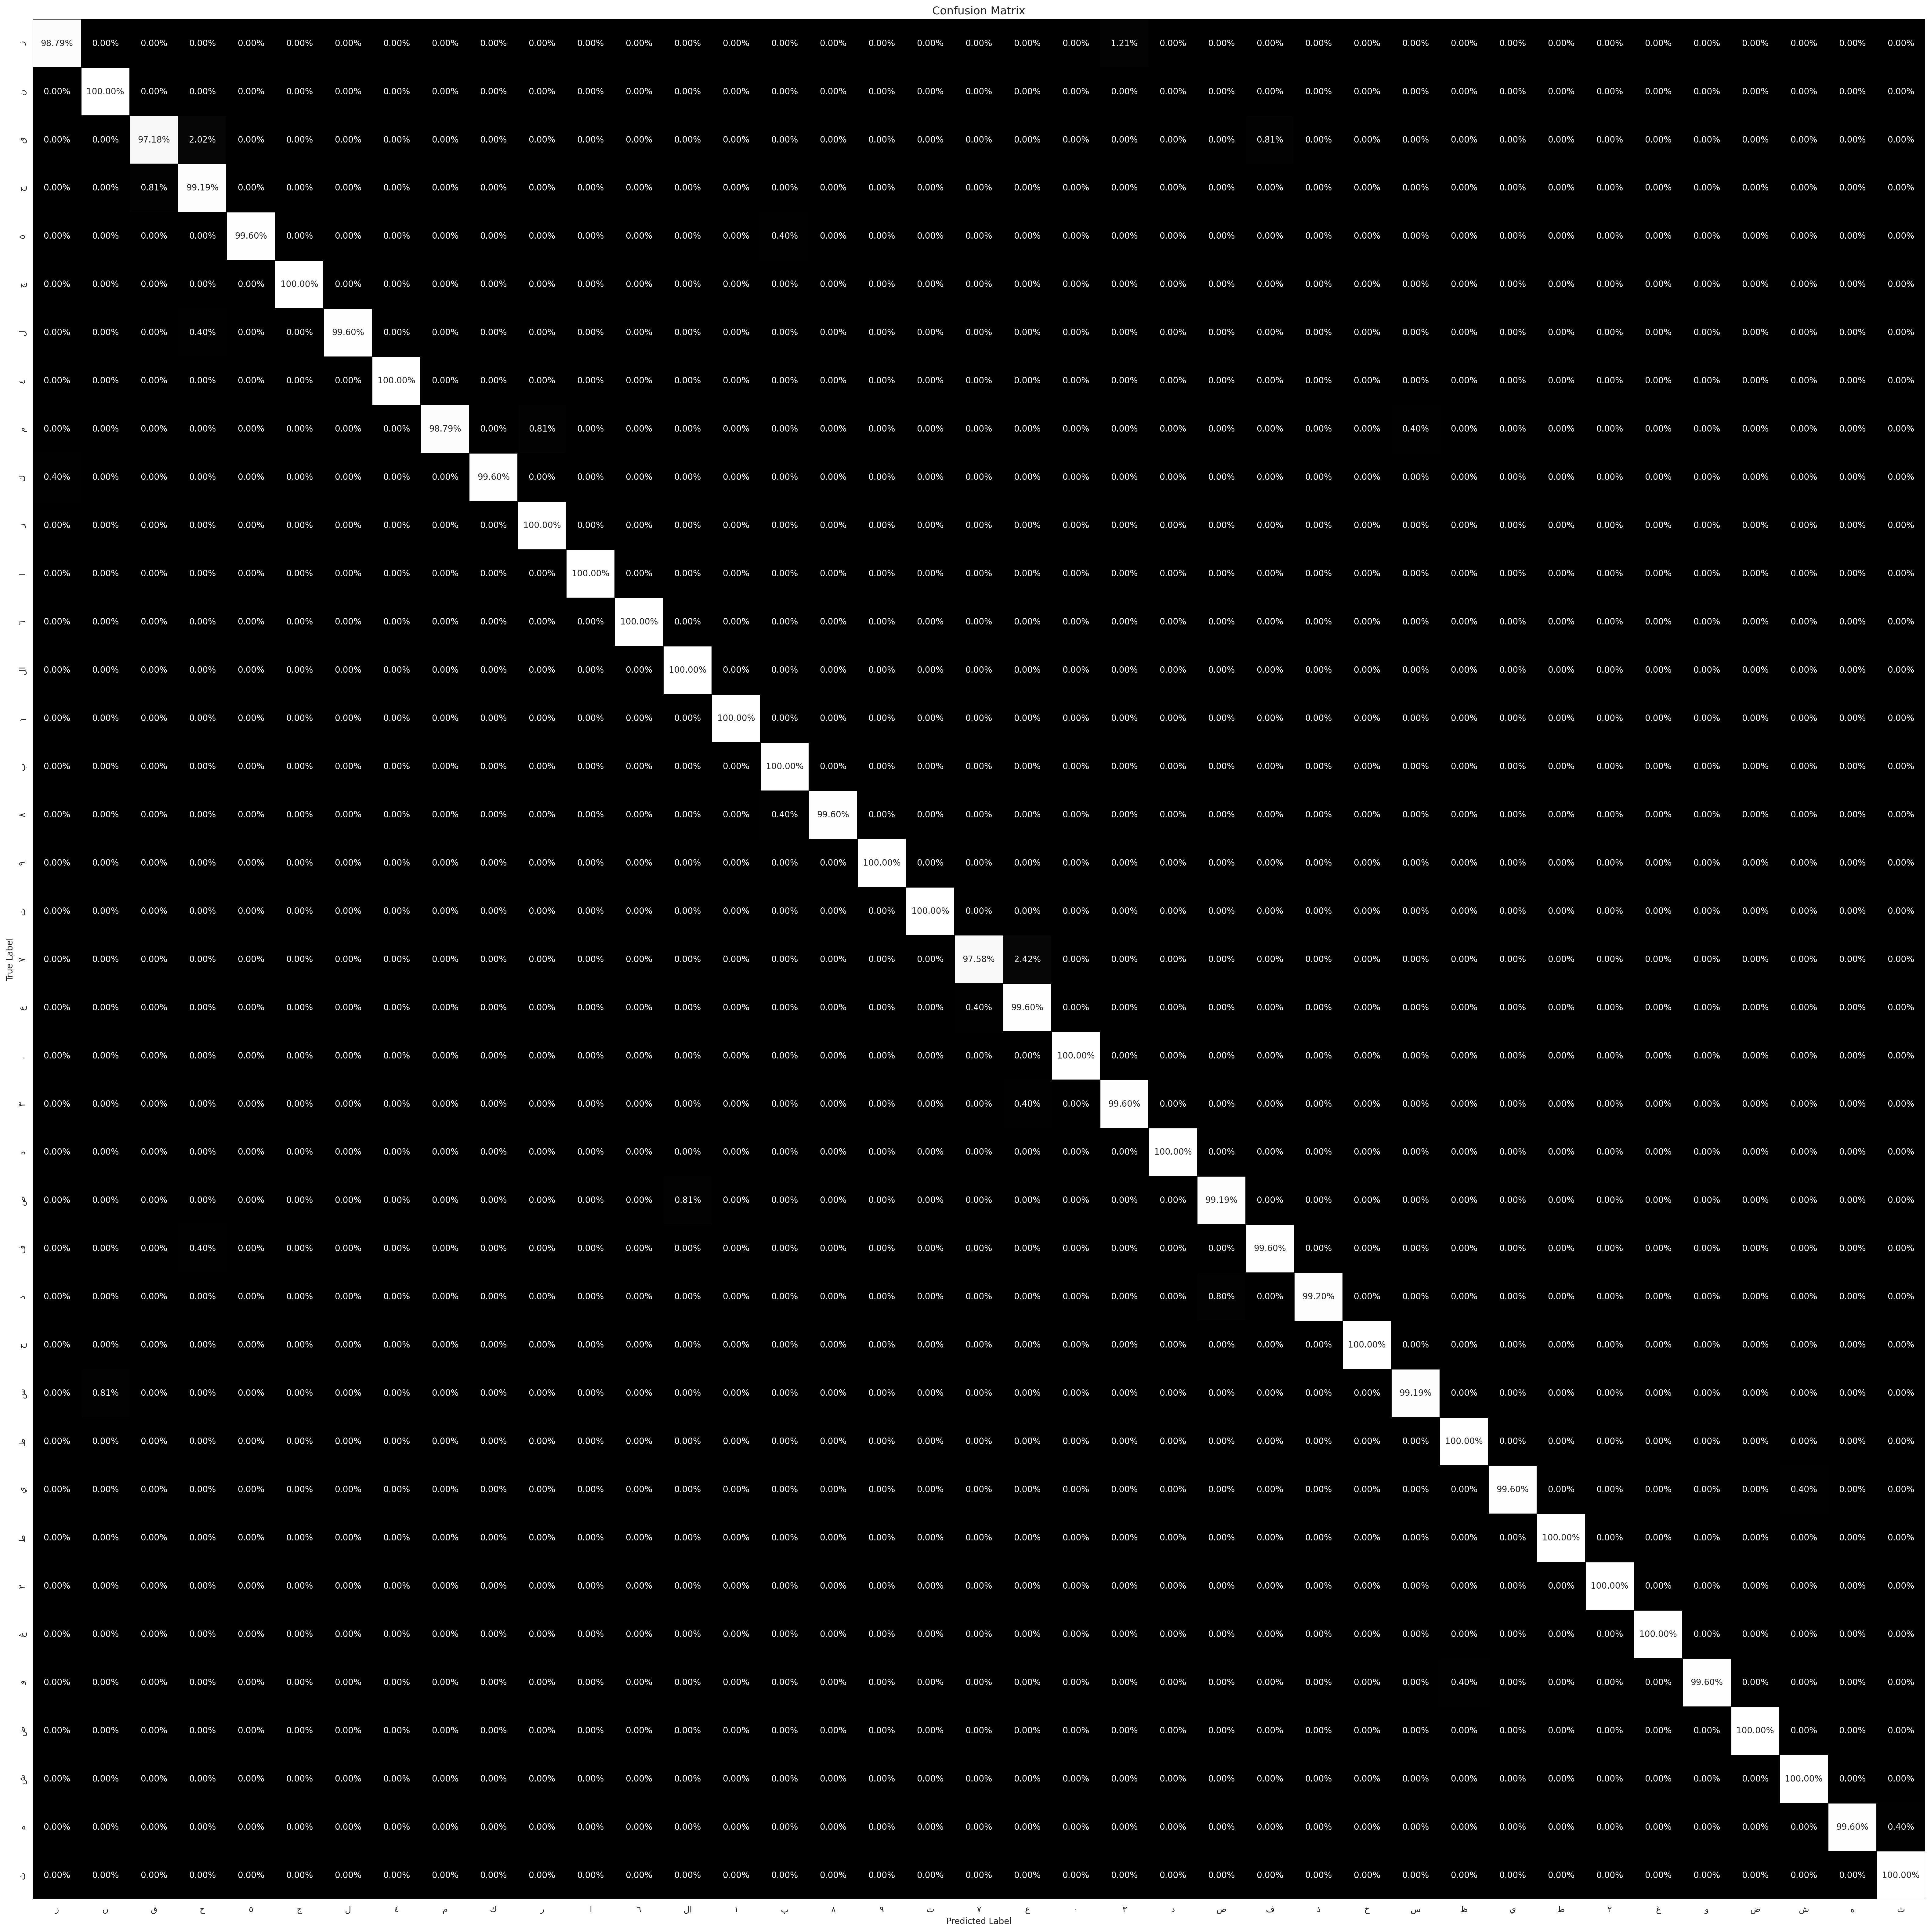

Accuracy for class ( ز ) : 98.79%
Class (ز) was wrongly seen as class (٣) in 1.21% of cases

Accuracy for class ( ن ) : 100.00%

Accuracy for class ( ق ) : 97.18%
Class (ق) was wrongly seen as class (ح) in 2.02% of cases
Class (ق) was wrongly seen as class (ف) in 0.81% of cases

Accuracy for class ( ح ) : 99.19%
Class (ح) was wrongly seen as class (ق) in 0.81% of cases

Accuracy for class ( ٥ ) : 99.60%
Class (٥) was wrongly seen as class (ب) in 0.40% of cases

Accuracy for class ( ج ) : 100.00%

Accuracy for class ( ل ) : 99.60%
Class (ل) was wrongly seen as class (ح) in 0.40% of cases

Accuracy for class ( ٤ ) : 100.00%

Accuracy for class ( م ) : 98.79%
Class (م) was wrongly seen as class (ر) in 0.81% of cases
Class (م) was wrongly seen as class (س) in 0.40% of cases

Accuracy for class ( ك ) : 99.60%
Class (ك) was wrongly seen as class (ز) in 0.40% of cases

Accuracy for class ( ر ) : 100.00%

Accuracy for class ( ا ) : 100.00%

Accuracy for class ( ٦ ) : 100.00%

Accuracy for clas

In [66]:
# Normalize the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

num_classes = confusion_mtx.shape[0]
figsize = 40  # adjust as needed

f, ax = plt.subplots(figsize=(figsize, figsize), dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap="gist_yarg_r", linecolor="black", fmt='.2%', ax=ax, cbar=False, xticklabels=all_entities_names, yticklabels=all_entities_names)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=13)

plt.savefig('confusion_matrix.png', dpi=300)
plt.show()


# Print accuracy for each class
for i in range(num_classes):
    true_positives = confusion_mtx[i, i]
    accuracy = true_positives * 100  # convert to percentage
    print(f"Accuracy for class ( {all_entities_names[i]} ) : {accuracy:.2f}%")

    # Print confusion with other classes
    for j in range(num_classes):
        if i != j and confusion_mtx[i, j] > 0:
            confusion = confusion_mtx[i, j] * 100  # convert to percentage
            print(f"Class ({all_entities_names[i]}) was wrongly seen as class ({all_entities_names[j]}) in {confusion:.2f}% of cases")
    print()        

In [67]:
# 14 --------------------------------------------------------- Execution Time
# region
# @title 14 - Execution time  { display-mode: "form" }


end_time = time.time()
execution_time = end_time - start_time

hours = execution_time // 3600
minutes = (execution_time % 3600) // 60
seconds = execution_time % 60

print("Execution Time: ", int(hours), "hours", int(minutes), "minutes", int(seconds), "seconds")




Execution Time:  0 hours 39 minutes 47 seconds


In [68]:
# --------------------------------------------------------- reference codes
# region
#  @title  reference codes { display-mode: "form" }

# from google.colab import drive
# drive.mount('/content/gdrive')

# import zipfile
# import os
# extract_source = "/content/gdrive/My Drive/GUC Bachelor : Arabic Image-to-Letters Script Recognition/data set/data set 2.zip"
# extract_destination = "/content/extracted_from_drive"
# zip_ref = zipfile.ZipFile(extract_source, 'r')
# print("extracting...")
# zip_ref.extractall(extract_destination)
# extracted_folder_name = os.listdir(extract_destination)[0]
# zip_ref.close()
# print("extracted files from drive to colab successfully !")
# all_entities_path = os.path.join(extract_destination, extracted_folder_name)


# def get_corrupted_files_paths(all_entities_path):
#     all_entities_names = os.listdir(all_entities_path)
#     corrupted_file_paths = set()
#     print("\nVerifying all files are non-corrupted images...")
#     for entity_name in all_entities_names:
#         entity_path = os.path.join(all_entities_path, entity_name)
#         for filename in os.listdir(entity_path):
#             file_path = os.path.join(entity_path, filename)
#             if not image_is_ok(file_path):
#                 print(f"File {file_path} is corrupted and will be skipped.")
#                 corrupted_file_paths.add(file_path)
#     print("Your data is ok." if not corrupted_file_paths else "Done reporting error files.")
#     return corrupted_file_paths

